<a href="https://colab.research.google.com/github/xrsrke/fsdl-website/blob/main/docs/blog/posts/megatron-lm-parallelism/megatron_lm_parallelism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Why?



Large language models are large.

They are so large that even
the latest and greatest hardware accelerators, like
[NVIDIA's H100 GPU](https://lambdalabs.com/blog/nvidia-h100-gpu-deep-learning-performance-analysis),
cannot fit all the calculations that transform
input text into output text and compute the information
used to make the model better during training.

That makes training large language models a distributed programming problem,
where the work of computing an output is split, or _distributed_,
across multiple accelerators or machines.

That's common enough for neural networks:
it's actually pretty typical for training
to require many GPUs,
and the simple solution is to split work
across data points, which
[isn't so hard](https://lightning.ai/docs/pytorch/stable/accelerators/gpu_intermediate.html?highlight=distributed%20data%20parallel).

But for the largest models,
things are yet worse:
you can't fit all the calculations
for the outputs of _even a single layer_
working on _even a single datapoint_
on one accelerator.

So training large language models requires
multiple layers of parallelization.

And despite the increases in scale
and the rapid pace of innovation in language model applications
in the past few years (and even months!),
the best reference for understanding the fundamentals of how that problem
is posed and solved is still a paper from 2020:
[_Megatron-LM: Training Multi-Billion Parameter Language Models Using Model Parallelism_](https://arxiv.org/abs/1909.08053).

In this blog post/notebook,
we'll walk through the main ideas in that paper.
Our goal will be to build up an understanding of how to implement
a Megatron-style linear layer.

We'll use that understanding to implement
`ColumnParallelLinear` in PyTorch.

## 1. Three Nested Parallelizations


### Data Parallelism

Parallelize by splitting up the data.

Each worker gets a piece of a batch and is responsible for running their own replica of the model on it.

Easy! Fun, even! Elements of a batch should have nothing to do with one another.

Synchronization: share gradients.

### Pipeline Parallelism

Parallelize by splitting up the model into distinct steps --
by layer, typically.

Each worker gets assigned one or more layers.

Note, this is also known as "vertical splitting",
because distributed systems people like
to write neural networks going left-to-right
instead of bottom-to-top,
as is [ancient tradition](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf)
in the world of NN research.

We prefer the term "pipeline parallelism"
because it's clearer and more evocative.

Synchronization: implemented naively,
during training a worker needs to wait for
the rest of the forward and beginning of the backward pass to complete before they can move forward.
"Bubbles".

Notice that after you've split up your batch into microbatches,
you can then further split up the model running on each microbatch:
model parallelism is nested within data parallelism.
And the only thing different model groups need to share is gradients.

### Tensor Parallelism

Parallelize by splitting up matrix multiplications.

Each worker gets assigned a piece of a matrix multiplication.

This is the trickiest bit, because more information
needs to be communicated between workers, and it's where the Megatron-LM paper makes its intellectual contribution.

But notice that if you do it right, tensor parallelism can be nested inside pipeline parallelism,
which is nested inside data parallelism.

That's three levels of parallelization,
and that degree of decomposition is what it takes to scale models to 10s or 100s of billions of parameters.

## 2. Megatron-LM: A Recipe for Combining Pipeline & Tensor Parallelism for Transformers

Data parallelism is straightforward enough --
in principle, it's just a matter of taking whatever you're doing for a batch size that you're parallelizing with other techniques
and then "copying" it to multiple instances
that each have their own smaller dataset
to draw microbatches from
and which share gradients at the end of each batch.

Megatron-LM is all about the harder part,
what you're parallelizing within a microbatch.

At high-level, Megatron-LM first breaks down a model
into different stages,
with each stage having several layers -
that's our pipeline parallelism.

Within each layer of a given stage in the pipeline,
the computation is divided into smaller sections,
with each section assigned to a different GPU -
that's our tensor parallelism.

To make sure we do our parallelization efficiently,
we need to be smart when we define the "sections"
of our computation.

For a matrix multiplication,
there are two choices:
splitting by row and splitting by column.

But for most neural network layers,
there's only one sensible choice:
split along the neuron dimension.
That way, you can calculate the output
of your non-linearity without communication
between workers.

## 3. Let’s implement `ColumnLinearParallel` from scratch


This is a parallelized version of a linear layer where we parallelize by column. [[Megatron's ColumnLinearParallel]](https://github.com/NVIDIA/Megatron-LM/blob/060415572f4365a2e895f8036c4e37dad0efbdf5/megatron/core/tensor_parallel/layers.py#L418)

### But why `Column` parallel?

There are, roughly speaking, two kinds of matrices:
- matrices that represent a collection of _vectors_
- matrices that represent a collection of _functions to apply to vectors_

A single matrix can switch between being one or the other,
depending on how it's used,
but most of the time a matrix only does one of those two things.

For example, a batch of data is a collection of vectors, while the weights of a layer in a neural network are a collection of functions to apply to vectors -- each of which is what some might call a "neuron".

When we distribute work,
we always want to split such that
the different pieces of the computation are as independent as possible.

For a collection, that's the dimension that goes across
different elements of the collection.

So when we're parallelizing a batch,
that means splitting the different entries in the batch
onto different workers.

And when we're parallelizing across a layer,
we want to split the different neurons onto different workers.

In the conventions of PyTorch,
that means we want to split the weights along
their last dimension, the columns:

```python
# [batch, n_outputs] = [batch, n_inputs] @ [n_inputs, n_outputs] + [n_outputs]
out = inputs @ weights + biases
```

In [ ]:
import torch

torch.random.manual_seed(117)

world_size = 4
batch_size, input_size, output_size = 10, 16, 12

inputs = torch.randn(2, input_size, requires_grad=False)
weights = torch.randn(output_size, input_size, requires_grad=True)
biases = torch.randn(output_size, requires_grad=True)

outputs = torch.matmul(inputs, weights.T) + biases

In [ ]:
def compute_column_parallel_linear(inputs, weights, biases, n_partitions):
    num_columns = weights.shape[-1]  #

    # partition into groups of "neurons"
    partition_size = num_columns // n_partitions
    w1, w2 = weights[:partition_size, :], weights[partition_size:, :]

    # now these can run independently
    out1, out2 = torch.matmul(inputs, w1.T), torch.matmul(inputs, w2.T)

    # and then we get the final result by combining them -- along the same dimension we split
    out = torch.cat([out1, out2], dim=-1)

    return out + biases

In [ ]:
outputs_parallel = compute_column_parallel_linear(inputs, weights, biases, n_partitions=4)

assert torch.equal(outputs, outputs_parallel)


In summary, the `ColumnParallelLinear` class divides the work of a linear layer across multiple processes. It does this by dividing the output dimension of the layer among the processes. Each process then computes its portion of the output and the gradients during the forward and backward passes, respectively. After the forward pass, the outputs from all the processes are gathered together to create the final output tensor. During the backward pass, the gradients are distributed across all the processes, and each process uses its portion of the gradient to update its parameters.

In [ ]:
from torch import nn
import torch.nn.functional as F

class ColumnParallelLinear(torch.nn.Module):
    def __init__(self, input_size, output_size, world_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self._output_size_per_partition = output_size // world_size

        self.weight = nn.Parameter(torch.randn(
            self._output_size_per_partition,
            self.input_size,
        ))
        self.bias = nn.Parameter(torch.randn(
            self._output_size_per_partition,
        ))

    def forward(self, input):
        output_parallel = F.linear(f.apply(input), self.weight, self.bias)
        outputs = g.apply(output_parallel)
        return outputs

In [ ]:
class f(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_output):
        torch.distributed.all_reduce(
            grad_output,  # modified in-place!
            op=torch.distributed.ReduceOp.SUM
        )
        return grad_output

In [ ]:
class g(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        world_size = torch.distributed.get_world_size()

        inputs = [torch.empty_like(input) for _ in range(world_size)]

        torch.distributed.all_gather(inputs, input)

        inputs = torch.cat(inputs, dim=-1)

        return inputs

    @staticmethod
    def backward(ctx, grad_output):
        rank = torch.distributed.get_rank()

        world_size = torch.distributed.get_world_size()

        dim_size = grad_output.shape[-1]

        dim_size_per_partition = dim_size // world_size

        grad_chunks = torch.split(grad_output, dim_size_per_partition, dim=-1)

        return grad_chunks[rank]

### Explain

From the `f` class

- `output = F.linear(input, self.weight, self.bias)`: The output partition corresponding to the current process.

From the `g` class

- `inputs = [torch.empty_like(input) for _ in range(world_size)]`: This line creates an outputs list with empty tensors that have the same shape as `input`. These tensors will be used to store the output of each process.

- `torch.distributed.all_gather(inputs, input)`: The `torch.distributed.all_gather` function is called to gather the input from all processes in the distributed group and store them in the `inputs` list.

From the `ColumnParallelLinear` class

- `self.output_size_per_partition = output_size // world_size`: This line calculates the output size for each partition by dividing the total output size by the number of partitions. This is done because the output dimension of the linear layer is divided among multiple processes, and each process will handle its corresponding portion of the output dimension.

- `self.weight = nn.Parameter(torch.empty(self.output_size_per_partition, self.input_size))`: This line initializes the weight parameter for the current process. Since each process is responsible for its own portion of the output dimension.

In [ ]:
outputs.sum().backward()

weight_grads = weights.grad.detach().requires_grad_(False)
bias_grads = biases.grad.detach().requires_grad_(False)

In [ ]:
import os

def run_parallel(
    rank, world_size,
    input_size, output_size,
    inputs, weights, biases, outputs,
    weight_grads, bias_grads
):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12359'
    torch.distributed.init_process_group(
        "gloo",
        rank=rank,
        world_size=world_size
    )

    torch.use_deterministic_algorithms(True)
    torch.random.manual_seed(rank)

    model = ColumnParallelLinear(input_size, output_size, world_size)

    # Partition the weights and biases and assign to the model
    partition_size = weights.shape[0] // world_size
    partition_start, partition_end = rank * partition_size, (rank + 1) * partition_size

    model.weight.data = weights[partition_start: partition_end].detach().requires_grad_(True)
    model.bias.data = biases[partition_start: partition_end].detach().requires_grad_(True)

    outputs_parallel = model(inputs.detach().requires_grad_(False))
    outputs_parallel.sum().backward()

    print(f"rank={rank}, parallel_output.shape: {outputs_parallel.shape}, non_parallel_output.shape: {outputs.shape}\n")
    print(f"rank={rank}, is the forward correct? {torch.allclose(outputs_parallel, outputs)}\n")
    print(f"rank={rank}, is the gradient of the weight correct? {torch.allclose(model.weight.grad, weight_grads[rank])}\n")
    print(f"rank={rank}, is the gradient of the bias correct? {torch.allclose(model.bias.grad, bias_grads[rank])}\n")

    torch.distributed.destroy_process_group()

In [ ]:
from torch.multiprocessing import Process

processes = []

for rank in range(world_size):
    p = Process(target=run_parallel, args=(
        rank, world_size,
        input_size, output_size,
        # Because PyTorch does not support sending tensors
        # that require gradients through inter-process communication
        # we need to detach them from the computational graph
        inputs, weights.detach(), biases.detach(), outputs.detach(),
        weight_grads, bias_grads
    ))
    processes.append(p)
    p.start()

for p in processes:
    p.join()

## 2. Distributed Communication



When we train a model in a distributed manner, there are four atomic operations in distributed communication that we need to perform

- Broadcast: We start with a tensor in one process and send it to all the other processes within the group. This is like sharing a piece of information with everyone in the group.
- Scatter: We take a tensor from one process and distribute its elements or chunks to all the other processes in the group. This is like dividing up a task among all the members in a team.
- Gather: We gather data from all the processes in the group and assemble it into a single tensor at the destination process. This is like collecting everyone’s input and putting it together in one place.
- Reduce: We take data from all processes in the group, apply a specific operation to it (like summing, multiplying, finding the minimum or maximum), and then store the result in the destination process. This is like combining everyone’s efforts and producing a single output

However, we can’t just directly use these operations from PyTorch like `torch.distributed.broadcast`. This is because in training, let’s say we are broadcasting a tensor `x` from device 0 to all devices 1, 2, and 3 during the forward pass. We must also support the reverse order during the backward pass. This means we have to write a broadcast operation that can handle both forward and backward passes.


In [ ]:
def is_grad_enable(input):
    return torch.is_grad_enabled() and input.requires_grad

def broadcast(inputs):
    return inputs.clone()

def reduce(inputs):
    world_size_of_parallel_group = torch.distributed.get_world_size()

    if world_size_of_parallel_group == 1:
        return inputs

    torch.distributed.all_reduce(
        inputs,
        op=torch.distributed.ReduceOp.SUM
    )

    return inputs

class Broadcast(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return broadcast(input)

    @staticmethod
    def backward(ctx, grad_output):
        return reduce(grad_output)

def broadcast_with_backward(inputs):
    if is_grad_enable(inputs):
        outputs = Broadcast.apply(inputs)
    else:
        outputs = broadcast(inputs)
    return outputs

In the forward pass, all the workers - different parts of our computer system - start with the same model parameters. One worker, usually the boss or ‘master’, gives these parameters to everyone else at the beginning of each cycle (`torch.distributed.broadcast()`).

In the backward pass, each worker does its own calculation. They all figure out their own gradients - basically, these are pointers that show how to tweak the model to improve it. After everyone’s done their calculations, they pool together their gradients. Each gradient represents the best direction to adjust the weight to minimize the loss with respect to its mini-batch. What we want is to find an average direction that works best for all the model replicas, so we pool all these gradients together (`torch.distributed.all_reduce()`). Then, we use this big pooled gradient to tweak the model’s parameters, making it a bit better with each cycle.

### 5. Pipeline Scheduler

So, let's say we have a big model with 10 layers, like a Transformer model. And we've got 5 devices (like GPUs) to run our model. We want to split the model into 5 parts (which we're gonna call 'partitions') and each part will run on one device.

But here's the problem. In a Transformer model, each layer needs the result from the previous layer before it can do its work. It's like a relay race, you can't start running until you've got the baton from the runner before you. So if we split our model into 5 parts, then the second part can't start until the first part is done, the third part can't start until the second part is done, and so on. That means that most of the time, most of our devices are just sitting around doing nothing. That's a bummer!

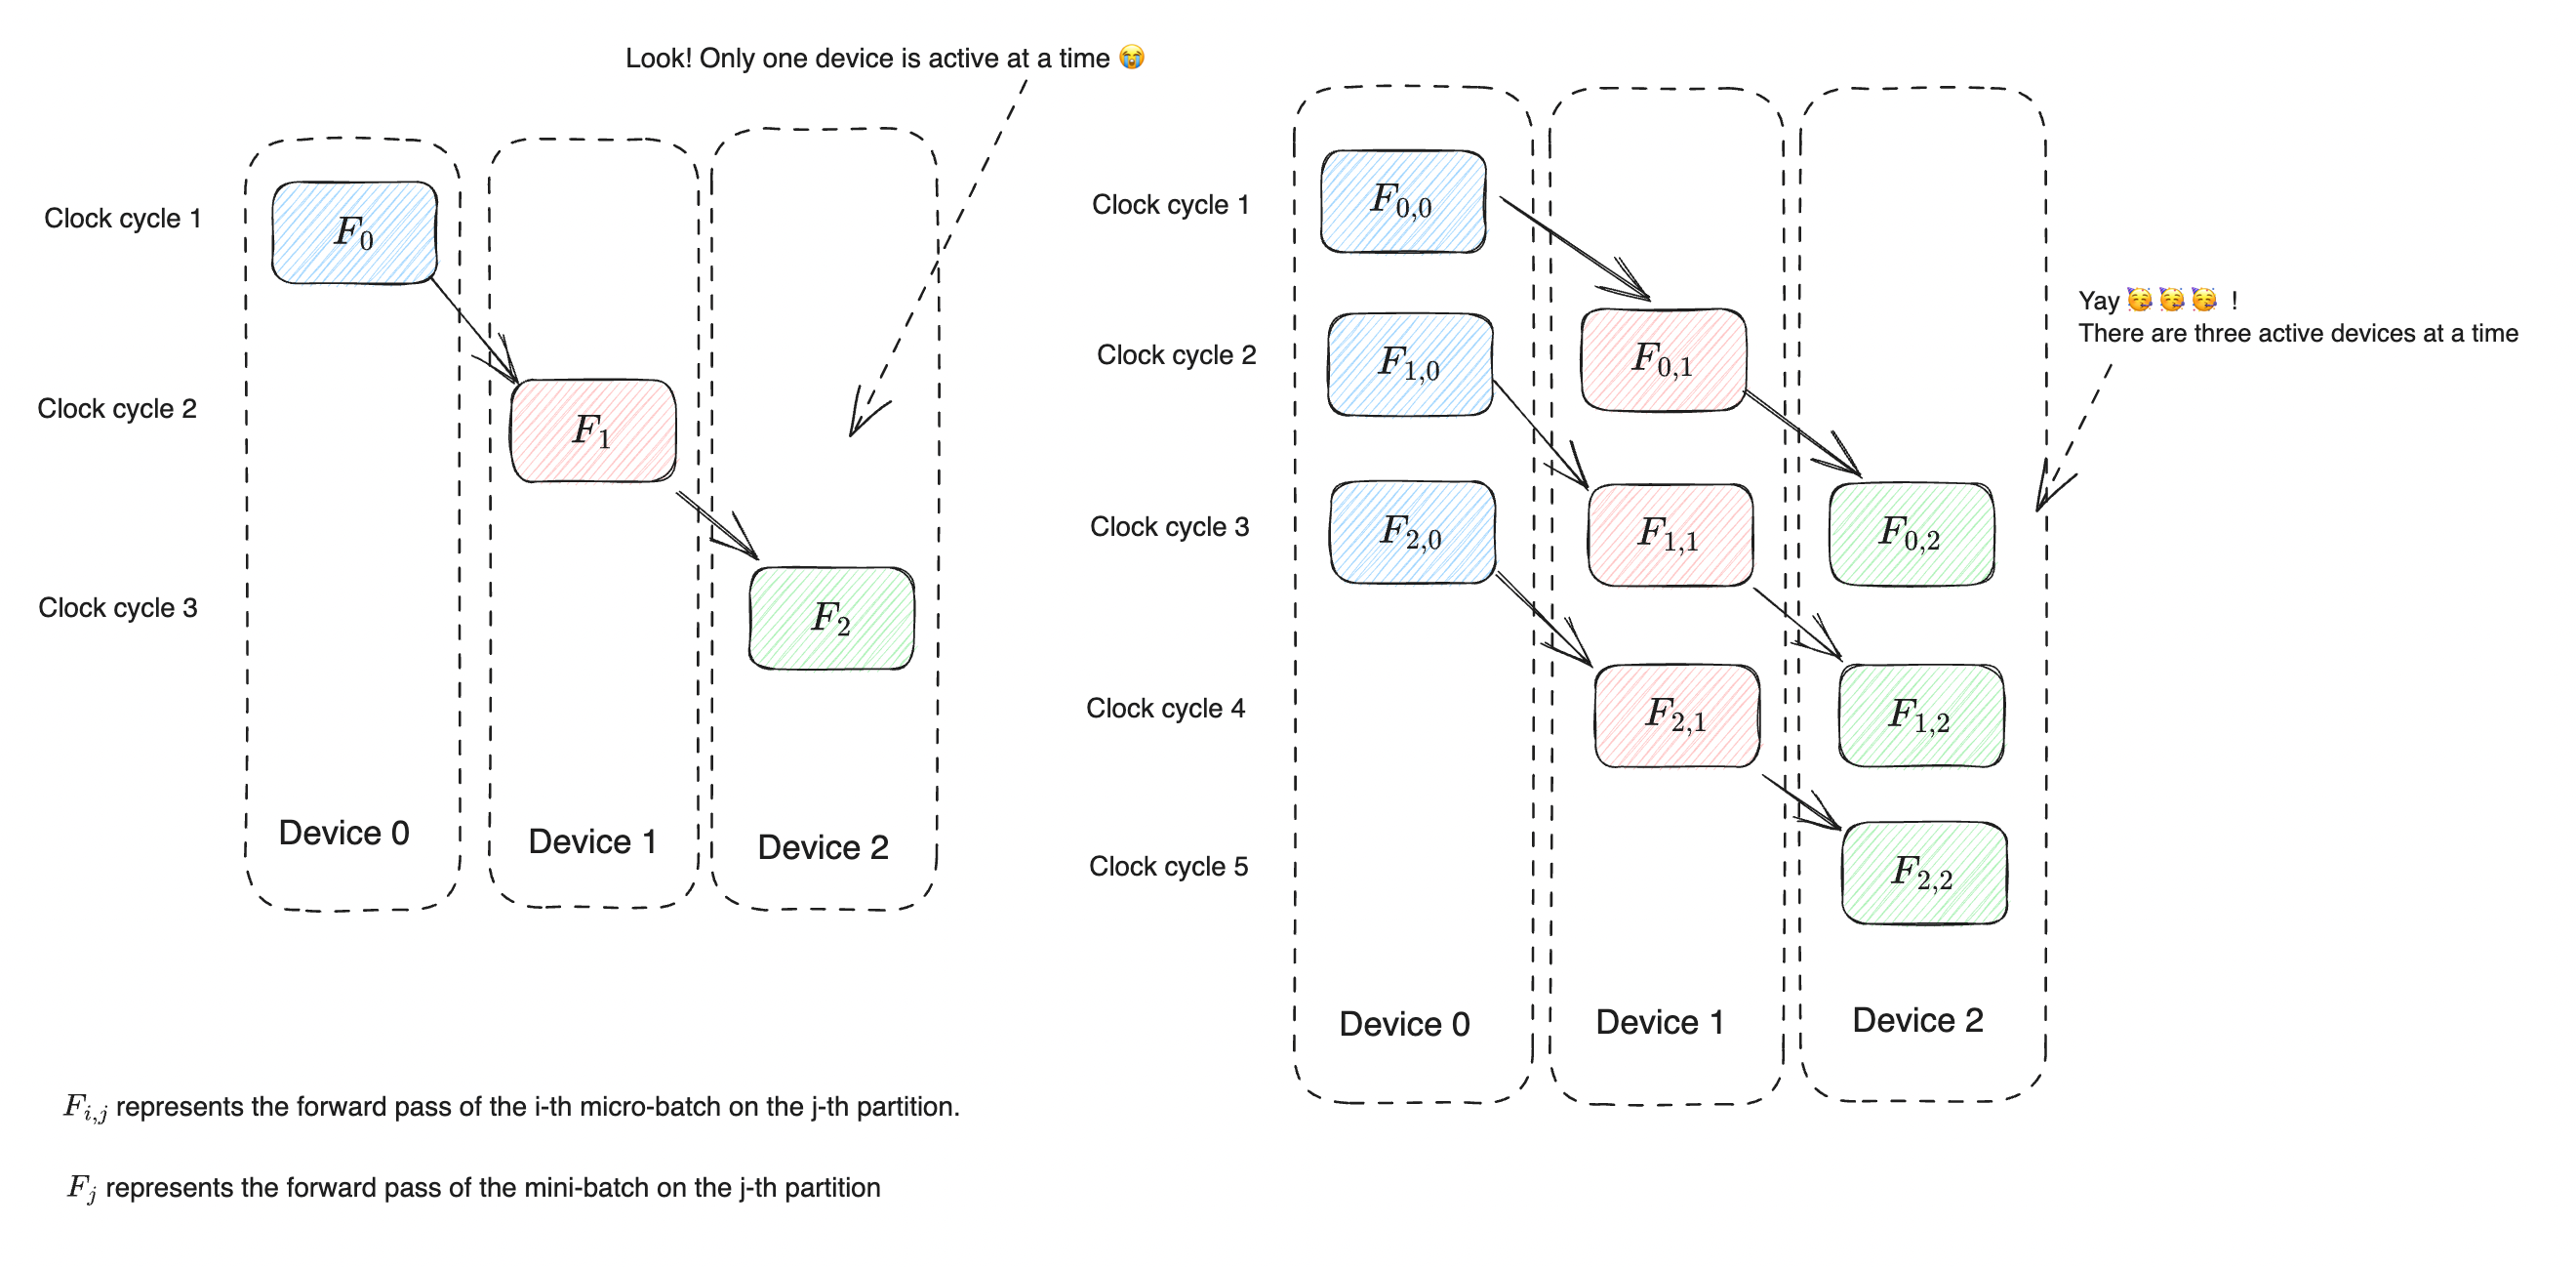

So what can we do? Here's where GPipe comes in. Instead of feeding a big batch of data to our model all at once, GPipe splits that batch into smaller chunks, which we're gonna call 'micro-batches'. And here's the trick: while one micro-batch is being processed by the second part of our model, the next micro-batch can start being processed by the first part of the model.

This way, there's always something for each part of the model to do. It's like a factory assembly line. As soon as one car is done with one station, it moves to the next station and a new car moves into the first station. This keeps all our devices busy (although they might still have some idle time, like when a worker in the factory is waiting for the next car to arrive).

So how does GPipe know what to do at each moment? That's the job of the GPipe's scheduler. The scheduler works in 'clock cycles'. For each clock cycle, it figures out which partitions should be active and which micro-batch each partition should work on.

In [22]:
n_microbatches = 4
n_partritions = 3

Because it takes `n_microbatches` clock cycles for all micro-batches to pass through the first partition. Once the last micro-batch enters the first partition, it needs to go through the remaining partitions. Since there are `n_partritions` partitions, this requires `n_partritions-1` additional clock cycles because the first clock cycle is already counted when the micro-batch enters the first partition.

Therefore, the total number of clock cycles is `n_microbatches+n_partritions-1`

In [23]:
n_clock_cycles = n_microbatches+n_partritions-1

In [24]:
n_clock_cycles

6

In [25]:
for clock_idx in range(n_clock_cycles):
    start_partrition = max(clock_idx+1-n_microbatches, 0)
    end_partrition = min(clock_idx+1, n_partritions)

    tasks = []
    for partrition_idx in range(start_partrition, end_partrition):
        microbatch_idx = clock_idx-partrition_idx
        task = (microbatch_idx, partrition_idx)
        tasks.append(task)
    
    print(f"Clock cycle {clock_idx}: {tasks}")

Clock cycle 0: [(0, 0)]
Clock cycle 1: [(1, 0), (0, 1)]
Clock cycle 2: [(2, 0), (1, 1), (0, 2)]
Clock cycle 3: [(3, 0), (2, 1), (1, 2)]
Clock cycle 4: [(3, 1), (2, 2)]
Clock cycle 5: [(3, 2)]


**Explain**

`min(clock_idx+1, n_partritions)`
- For each clock cycle, a new partrition actives in the pipeline. If we are currently in clock_idx, it means that clock_idx partritions have already been actived. 
- The next partritions will be `clock_idx+1`. However, we cannot exceed the total number of partitions (`n_partitions`), so we use the min function to limit the range.

### 6. Let's build an pipeline parallelism from scratch